In [7]:
!kaggle datasets download -d hereisburak/pins-face-recognition -p data/

Dataset URL: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition
License(s): CC0-1.0
100%|████████████████████████████████████████| 372M/372M [03:02<00:00, 2.16MB/s]
100%|████████████████████████████████████████| 372M/372M [03:02<00:00, 2.14MB/s]


In [9]:
!unzip -q data/pins-face-recognition.zip -d data/PINS/

In [10]:
!rm data/pins-face-recognition.zip

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Iterar pelo diretório PINS, iterando por cada pasta e criando um DataFrame com o nome da pessoa e o caminho da imagem
data = []
identity = 0

for person in os.listdir('../data/PINS/105_classes_pins_dataset'):
    for image in os.listdir(f'../data/PINS/105_classes_pins_dataset/{person}'):
        data.append((identity, person, f'{person}/{image}'))
    identity += 1
    
df = pd.DataFrame(data, columns=['id', 'person', 'path'])

df.to_csv('../data/PINS/pins.csv', index=False)

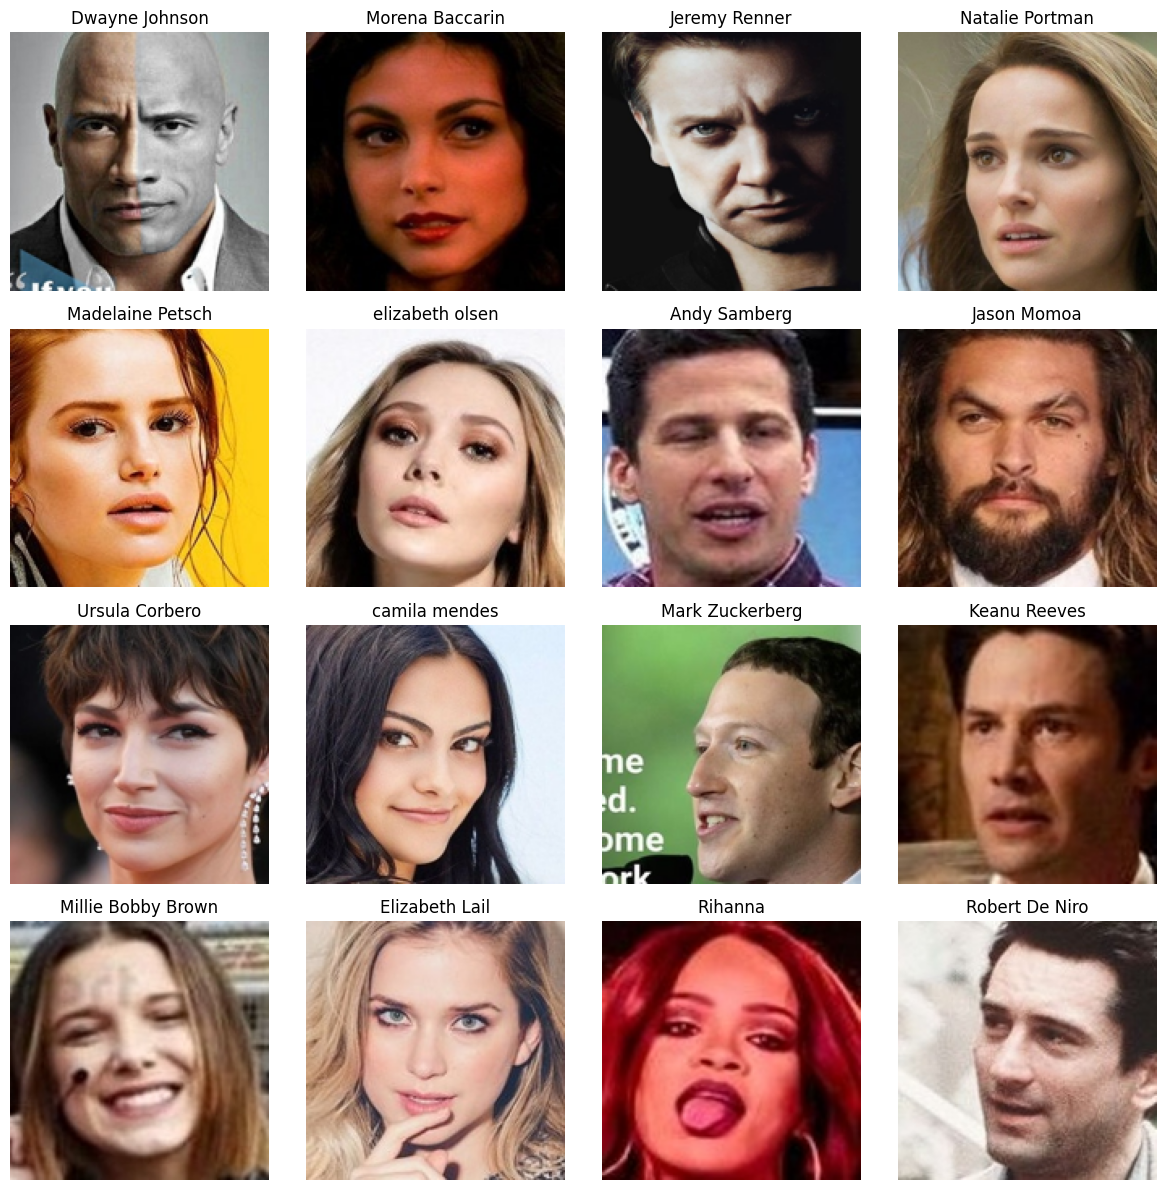

In [19]:
df_random = df.sample(n=16, random_state=np.random.RandomState())

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img_path = df_random.iloc[i, 2]
    img = Image.open(f'../data/PINS/105_classes_pins_dataset/{img_path}')
    img_resized = img.resize((160, 160))
    
    ax.imshow(img_resized)
    ax.set_title(df_random.iloc[i, 1].replace('pins_', ''))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
df.shape, df['id'].nunique()

((17534, 3), 105)

In [21]:
df['id'].value_counts().mean(), df['id'].value_counts().min(), df['id'].value_counts().max()

(166.9904761904762, 86, 237)

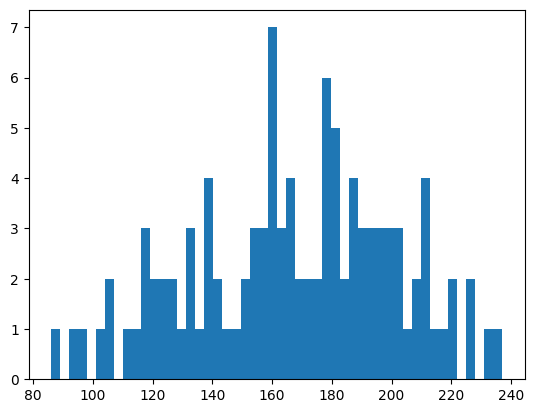

In [22]:
import matplotlib.pyplot as plt

plt.hist(df['id'].value_counts(), bins=50)
plt.show()

In [23]:
df_clean = df.groupby('id').filter(lambda x: len(x) >= 100)
df_clean.shape, df_clean['id'].nunique()

((17255, 3), 102)

# **Split**

Treino, teste e validação

Treino e teste: mesmos IDS, fotos diferentes
Validação: rostos nunca vistos

In [24]:
val_ids = df_clean['id'].value_counts().nsmallest(5).index
val_df = df_clean[df_clean['id'].isin(val_ids)].copy()

remaining_ids = df_clean[~df_clean['id'].isin(val_ids)]['id'].unique()
test_df = df_clean[df_clean['id'].isin(remaining_ids)].copy()
test_df = test_df.groupby('id').head(10)

train_df = df_clean[~df_clean.index.isin(test_df.index) & ~df_clean.index.isin(val_df.index)].copy()

In [25]:
# Renomear coluna id para id_original
train_df.rename(columns={'id': 'id_original'}, inplace=True)
val_df.rename(columns={'id': 'id_original'}, inplace=True)
test_df.rename(columns={'id': 'id_original'}, inplace=True)

# Resetar os índices
train_df.loc[:, 'id'], _ = pd.factorize(train_df['id_original'])
test_df.loc[:, 'id'], _ = pd.factorize(test_df['id_original'])
val_df.loc[:, 'id'], _ = pd.factorize(val_df['id_original'])

In [26]:
print(f"train_df: {train_df.shape[0]:,} imagens | {train_df['id'].nunique()} identidades | média de {train_df['id'].value_counts().mean():.2f} imagens por identidade")
print(f"test_df: {test_df.shape[0]:,} imagens | {test_df['id'].nunique()} identidades | média de {test_df['id'].value_counts().mean():.2f} imagens por identidade")
print(f"val_df: {val_df.shape[0]:,} imagens | {val_df['id'].nunique()} identidades | média de {val_df['id'].value_counts().mean():.2f} imagens por identidade")

train_df: 15,743 imagens | 97 identidades | média de 162.30 imagens por identidade
test_df: 970 imagens | 97 identidades | média de 10.00 imagens por identidade
val_df: 542 imagens | 5 identidades | média de 108.40 imagens por identidade


In [27]:
train_df.to_csv(os.path.join('../data/PINS/', 'train.csv'), index=False)
test_df.to_csv(os.path.join('../data/PINS/', 'test.csv'), index=False)
val_df.to_csv(os.path.join('../data/PINS/', 'val.csv'), index=False)

In [34]:
# Verificar a mesma pessoa em diferentes datasets (treino e teste)
erro = False
for i in range(train_df['id'].nunique()):
    if train_df[train_df['id'] == i].iloc[0]['person'] != test_df[test_df['id'] == i].iloc[0]['person']:
        print(f"Erro: {train_df[train_df['id'] == i].iloc[0]['person']} != {test_df[test_df['id'] == i].iloc[0]['person']}")
        erro = True

if not erro:
    print("Nenhum erro encontrado")

Nenhum erro encontrado
